**Initialization**

In [17]:
import numpy as np
from sklearn.manifold import TSNE

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

**Task 1: Data set**

Training inputs shape: (60000, 28, 28)
Training labels shape: (60000,)
Test inputs shape: (10000, 28, 28)
Test labels shape: (10000,)


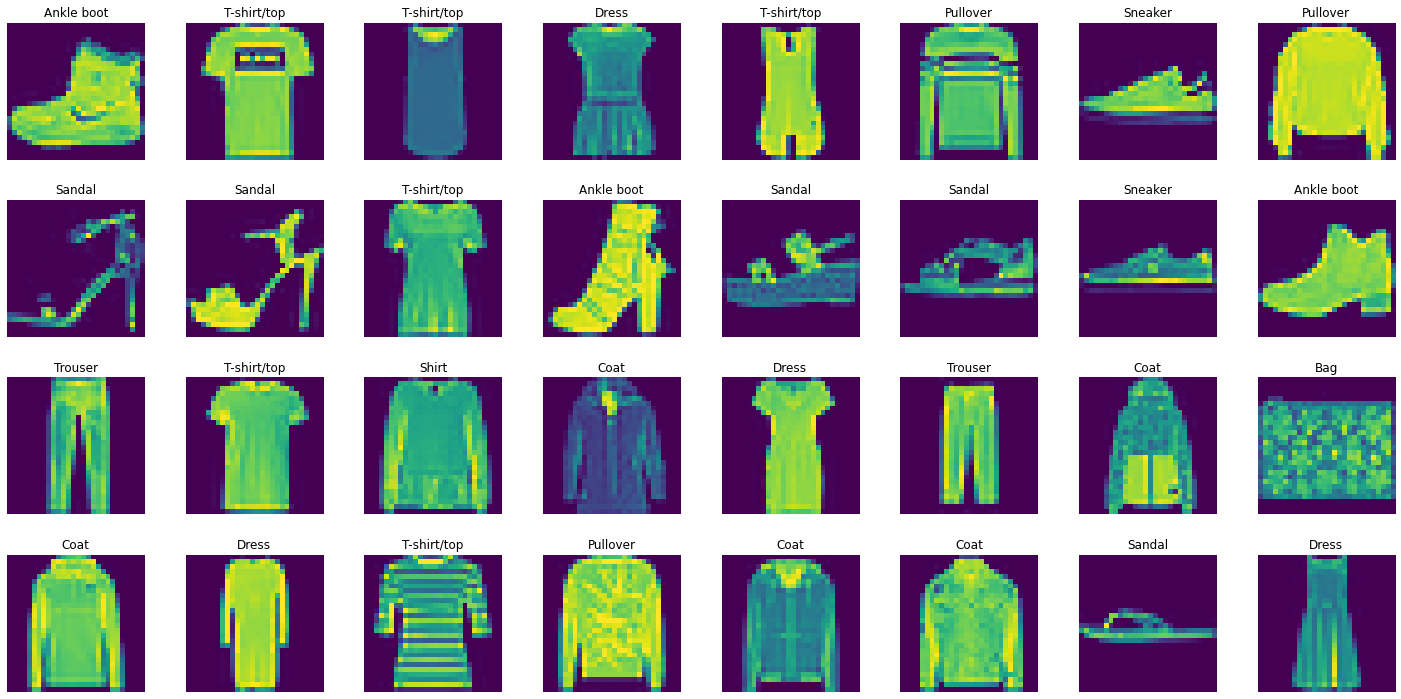

In [18]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline.

In [19]:
batch_size = 50

# Creates tensorflow datasets for the training and test inputs (images) and labels.
training_dataset_inputs = tf.data.Dataset.from_tensor_slices(training_inputs)
training_dataset_labels = tf.data.Dataset.from_tensor_slices(training_labels)
test_dataset_inputs = tf.data.Dataset.from_tensor_slices(test_inputs)
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)

# Adds an additional dimension to the input images (necessary for the convolutional layers).
training_dataset_inputs = training_dataset_inputs.map(lambda img : tf.expand_dims(img, -1))
test_dataset_inputs = test_dataset_inputs.map(lambda img : tf.expand_dims(img, -1))

# Zips together the training and test datasets.
training_dataset = tf.data.Dataset.zip((training_dataset_inputs, training_dataset_labels))
test_dataset = tf.data.Dataset.zip((test_dataset_inputs, test_dataset_labels))

# Conducts the normalization of the inputs (images).
training_dataset = training_dataset.map(lambda inp, tar: ((inp/255), tar))  
test_dataset = test_dataset.map(lambda inp, tar: ((inp/255), tar))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

**Task 2: Model**

**Task 2.1: Convolutional Autoencoder**

Class Encoder

In [20]:
# Description: The class Encoder defines the encoder of a convolutional autoencoder.
class Encoder(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Encoder, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = 80,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),      
                                         input_shape = (28, 28, 1))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.relu    
    self.conv_2 = tf.keras.layers.Conv2D(filters = 80,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',         
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))     
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.relu    
    self.flatten_layer = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(10, activation = None)


  # Description: This function conducts a forward step of the encoder.
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training 
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)
    x = self.flatten_layer(x)
    x = self.output_layer(x)
    return x                 

Class Decoder

In [21]:
# Description: The class Decoder defines the decoder of a convolutional autoencoder.
class Decoder(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Decoder, self).__init__()

    self.input_layer = tf.keras.layers.Dense(49)
    self.transp_conv_1 = tf.keras.layers.Conv2DTranspose(filters = 80,
                                                         kernel_size = 3,
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                                         bias_initializer = 'zeros',                               
                                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.relu    
    self.transp_conv_2 = tf.keras.layers.Conv2DTranspose(filters = 80,
                                                         kernel_size = 3,
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',         
                                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                                         bias_initializer = 'zeros',                               
                                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))    
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                         

    self.output_layer = tf.keras.layers.Conv2D(filters = 1,
                                               kernel_size = 3,
                                               strides = 1,
                                               activation = tf.keras.activations.sigmoid,
                                               padding = 'same')


  # Description: This function conducts a forward step of the decoder.
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.input_layer(x)
    # Reshapes the embedding, which was previously enlarged by the input_layer, into a feature map. First shape (batch_size)
    # needs to be -1, because the last batch often does not fit into the predefined batch_size.
    x = tf.reshape(x, [-1, 7, 7, 1])

    x = self.transp_conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.transp_conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.output_layer(x)
    return x    

Class Convolutional Autoencoder

In [22]:
# Description: The class ConvAutoencoder defines the convolutional autoencoder consisting of an encoder and a decoder.
class ConvAutoencoder(tf.keras.Model): 
  
  def __init__(self):
    super(ConvAutoencoder, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()


  # Description: This function conducts a forward step of the convolutional autoencoder. The boolean interpolate_betw_two_embeddings
  #              is used to differ between a normal training/ test call of the model and a call to obtain an interpolated decoded image
  #              based on the linear interpolation between the embedding of two images.
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training
  #              @returns: (prediction) x
  def call(self, x, training = True, interpolate_betw_two_embeddings = False):
    if interpolate_betw_two_embeddings == False:
      embeddings = self.encoder(x)
      output = self.decoder(embeddings)
      return output, embeddings  

# Second variant of calling the model to obtain an interpolated decoded image.
    elif interpolate_betw_two_embeddings == True:
      embeddings = self.encoder(x)
      interpolated_embeddings = np.zeros([50, 10])
      for embed in range(batch_size - 1):                                                           # Iterates over 1 batch of embeddings.
        interpolated_embeddings[embed] = np.float32(embeddings[embed + 1] - embeddings[embed])
      interpolated_embeddings[49] = embeddings[49] - embeddings[0]                                  # Last one needs to be calculated manually -> last and first element of tensor.
      interpolated_embeddings = tf.convert_to_tensor(interpolated_embeddings, dtype= tf.float32)
      interpolated_output = self.decoder(interpolated_embeddings)
      return interpolated_output                                                                    # Returns 50 interpolated, decoded images.

**Task 3 and 4: Training and Latent Space Analysis**

In [23]:
# Description: This function conducts a forward-step and the backpropagation of an autoencoder. 
#              Additionally, the average training loss is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training 
#              @returns: training_loss, training_accuracy
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction, _ = model(input, training)                                                   # Embedded input is not relevant during training.                                                    
      current_training_loss = loss_fn(input, prediction) + tf.math.reduce_sum(model.losses)    # The loss is calculated between original image (input) and the predicted image (prediction).
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())
  
  training_loss = np.mean(training_losses)
  return training_loss
  

# Description: This function determines the average test loss of an autoencoder. Additionally, the embedded data points of the 
#              first 1000 images are collected for later plotting. One original image and predicted image pair is picked
#              to visualize the training progress of the model. Also, an interpolated decoded image based on the linear 
#              interpolation between the embeddings of two images is obtained when the boolean "interpolate_betw_two_embeddings" is true.
#              @parameters: model, test_data, loss_fn, training
#              @returns: test_loss, test_accuracy
def test(model, test_data, loss_fn, training = False, interpolate_betw_two_embeddings = False):
  if interpolate_betw_two_embeddings == False: 
    test_losses = []
    embeddings = []
    corresponding_embedding_labels = []

    test_image_counter = 0
    example_input_img = tf.zeros([28, 28, 1], tf.int32)
    example_prediction_img = tf.zeros([28, 28, 1], tf.int32)
    for (input, target) in test_data:
      prediction, embedded_input = model(input, training, interpolate_betw_two_embeddings)   # Embedded input is relevant during testing (needs to be saved for the first 1000 images). 

      current_test_loss = loss_fn(input, prediction)
      test_losses.append(current_test_loss.numpy()) 

# The first 1000 embedded test images are used for the latent space analysis.
      if test_image_counter < 1000:                                          
        embeddings.append(embedded_input)
        corresponding_embedding_labels.append(target)
        test_image_counter += batch_size

# One original image and predicted image pair is picked in each test epoch to get an overview over the training progress.
        if test_image_counter == 1000:                                         
          example_input_img = input[batch_size - 1]
          example_prediction_img = prediction[batch_size - 1]
    
    test_loss = np.mean(test_losses)
    return test_loss, example_input_img, example_prediction_img, embeddings, corresponding_embedding_labels

# Second variant of calling the model to obtain an interpolated decoded image.
  elif interpolate_betw_two_embeddings == True:
    example_interpolated_prediction_img = tf.zeros([28, 28, 1], tf.int32)

    for (input, target) in test_data:
      prediction = model(input, training, interpolate_betw_two_embeddings) 
      example_prediction_img = prediction[batch_size - 1]
      return example_prediction_img

Epoch 0
Example image with its reconstructed counterpart: 


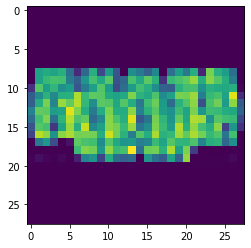

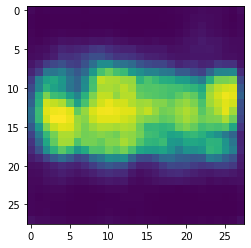

Embedded data points of the first 1000 images colored according to their class: 


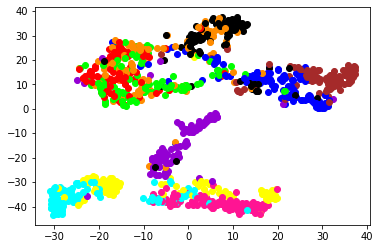

Training loss: 0.08389842
Test loss: 0.030281745
Interpolated example: 


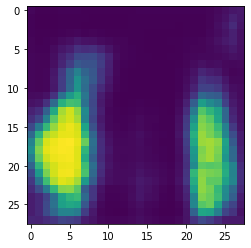

Epoch 1
Example image with its reconstructed counterpart: 


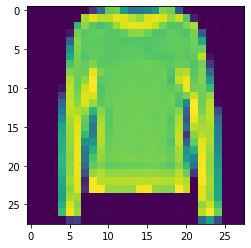

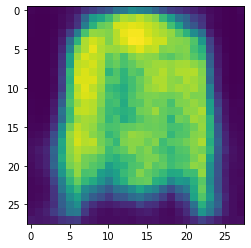

Embedded data points of the first 1000 images colored according to their class: 


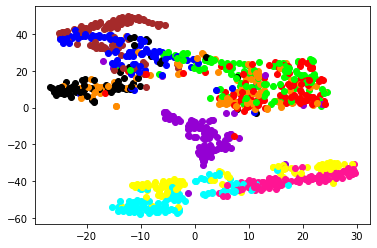

Training loss: 0.028185828
Test loss: 0.031611975
Interpolated example: 


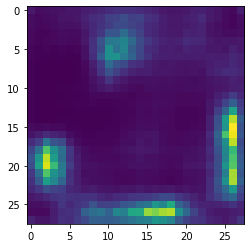

Epoch 2
Example image with its reconstructed counterpart: 


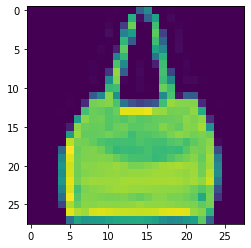

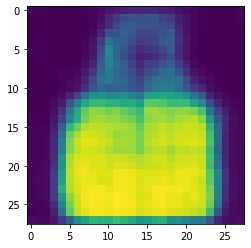

Embedded data points of the first 1000 images colored according to their class: 


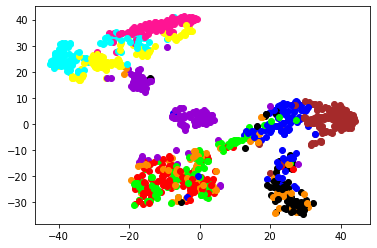

Training loss: 0.027089361
Test loss: 0.030375285
Interpolated example: 


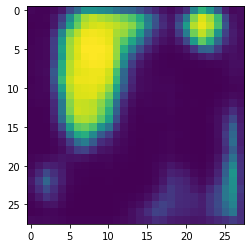

Epoch 3
Example image with its reconstructed counterpart: 


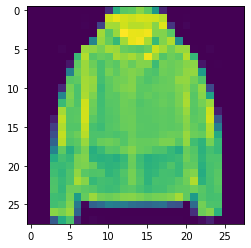

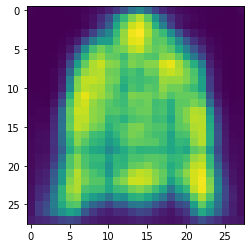

Embedded data points of the first 1000 images colored according to their class: 


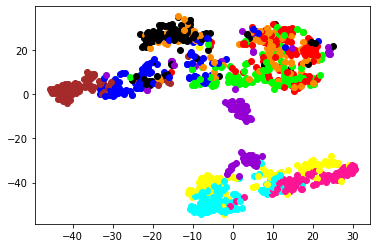

Training loss: 0.026347661
Test loss: 0.029783959
Interpolated example: 


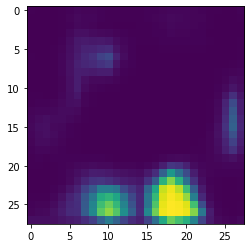

Epoch 4
Example image with its reconstructed counterpart: 


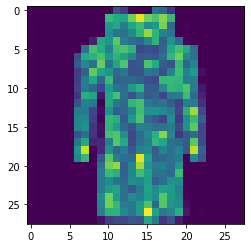

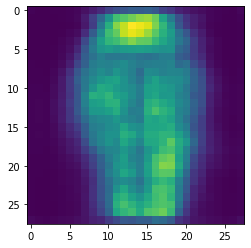

Embedded data points of the first 1000 images colored according to their class: 


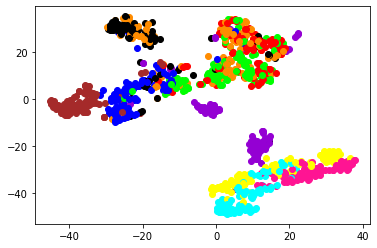

Training loss: 0.026038771
Test loss: 0.028564753
Interpolated example: 


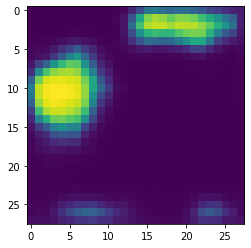

Epoch 5
Example image with its reconstructed counterpart: 


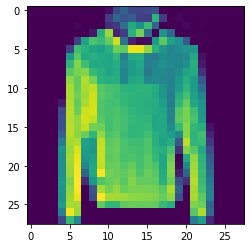

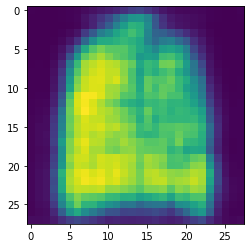

Embedded data points of the first 1000 images colored according to their class: 


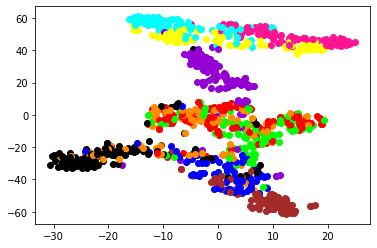

Training loss: 0.025540816
Test loss: 0.024525516
Interpolated example: 


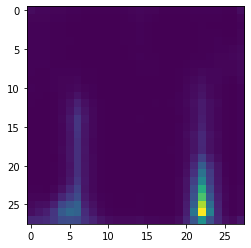

Epoch 6
Example image with its reconstructed counterpart: 


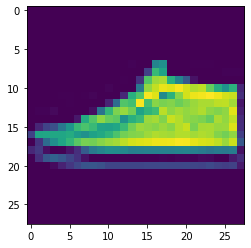

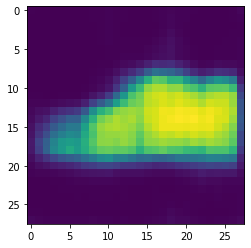

Embedded data points of the first 1000 images colored according to their class: 


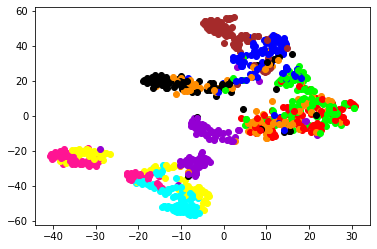

Training loss: 0.02536891
Test loss: 0.024201084
Interpolated example: 


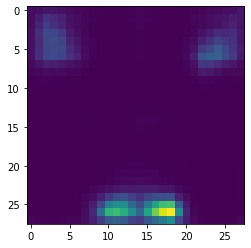

Epoch 7
Example image with its reconstructed counterpart: 


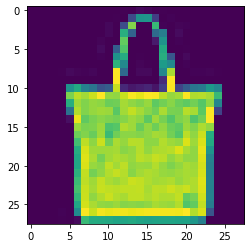

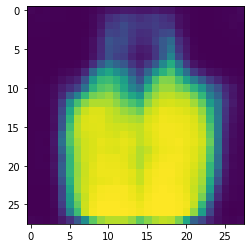

Embedded data points of the first 1000 images colored according to their class: 


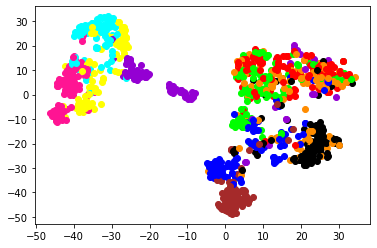

Training loss: 0.025241094
Test loss: 0.031949658
Interpolated example: 


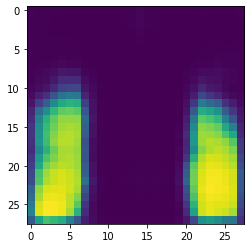

Epoch 8
Example image with its reconstructed counterpart: 


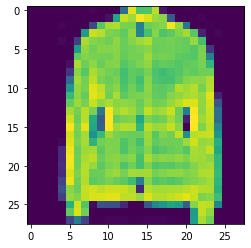

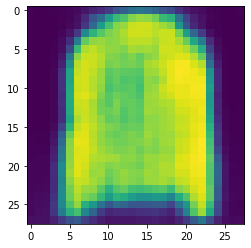

Embedded data points of the first 1000 images colored according to their class: 


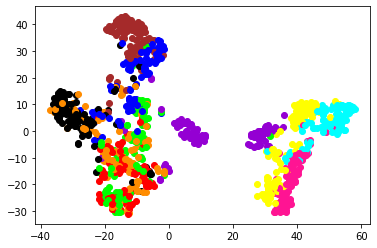

Training loss: 0.024986807
Test loss: 0.023623772
Interpolated example: 


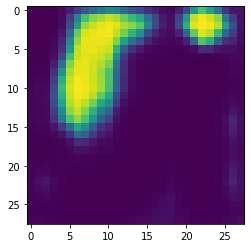

Epoch 9
Example image with its reconstructed counterpart: 


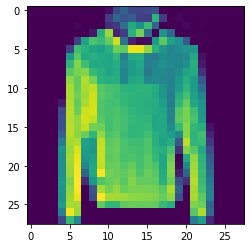

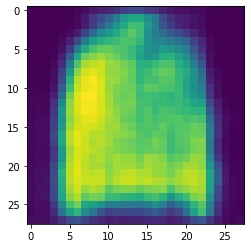

Embedded data points of the first 1000 images colored according to their class: 


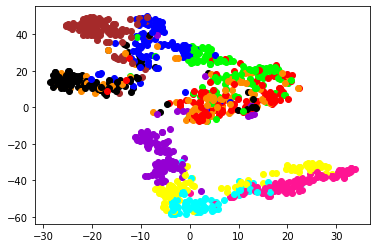

Training loss: 0.024904268
Test loss: 0.02373687
Interpolated example: 


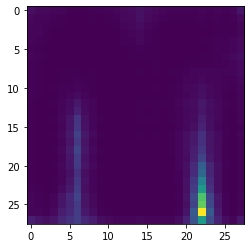

In [24]:
# Description: This part creates an objects of a convolutional autoencoder and executes the training and testing of the model in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, several visualizations during the training are conducted.
tf.keras.backend.clear_session()

model = ConvAutoencoder()

n_epochs = 10
learning_rate = 0.00075
loss_fn = tf.keras.losses.MeanSquaredError()                             # Mean squared error as loss-function.
optimizer = tf.keras.optimizers.Adam((learning_rate), amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
test_losses = []

# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    training_loss = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)

    test_loss, example_input_img, example_prediction_img, embeddings, corresponding_embedding_labels = test(model, test_dataset, loss_fn, training = False, interpolate_betw_two_embeddings = False)                              #, test_accuracy
    test_losses.append(test_loss)

    embeddings = tf.reshape(embeddings, [1000, 10])
    corresponding_embedding_labels = tf.reshape(corresponding_embedding_labels, [1000])
    reduced_embeddings = TSNE(n_components = 2).fit_transform(embeddings)

    # Example image with its reconstructed counterpart.
    print("Example image with its reconstructed counterpart: ")
    plt.imshow(tf.squeeze(example_input_img).numpy())
    plt.show()
    plt.imshow(tf.squeeze(example_prediction_img).numpy())
    plt.show()

    # Plots the embedded data points of the first 1000 images colored according to their class.
    print("Embedded data points of the first 1000 images colored according to their class: ")
    label_color_coding = ["black", "brown", "red", "blue", "lime", "yellow", "darkorange", "cyan", "darkviolet", "deeppink"]
    for embed in range(1000):
      current_label_color = label_color_coding[corresponding_embedding_labels[embed]]
      plt.scatter(reduced_embeddings[embed][0], reduced_embeddings[embed][1], color = current_label_color)
    plt.show()

    # Prints the training and test loss.
    print("Training loss: " + str(training_loss))
    print("Test loss: " + str(test_loss))

    # Interpolates linearly between the embeddings of two images and plots the reconstructed image.
    print("Interpolated example: ")
    example_interpolated_prediction_img = test(model, test_dataset, loss_fn, training = False, interpolate_betw_two_embeddings = True)
    plt.imshow(tf.squeeze(example_interpolated_prediction_img).numpy())
    plt.show()

The embedded data points of one class are mostly related to one area of the plot. Thus, the images of one class mostly result in similar embeddings. But these related areas are not really densely packed, so they refer to different areas of the plot. This is the case, because the embeddings were obtained by a convolutional autoencoder. The plot of a variational autoencoder would lead to a much denser representation of the different classes in the plot.

The linear interpolation of two embeddings of different images highlights the areas where the original images differ from each other. So these differences are represented in the corresponding embeddings as well.

**Visualization**


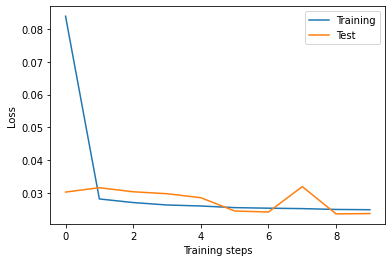

In [26]:
# Description: The figure shows the loss for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()